In [469]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [470]:
# Laste poll-of-polls data
df = pd.read_csv("../data/all_v2_data.csv", sep=",")

In [471]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [472]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [473]:
df.dropna(inplace=True)

In [474]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [475]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [476]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9,...,0.0,0.0,0.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-02-28,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2,...,0.0,0.0,0.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000


In [477]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_orig=df

In [478]:
df_en = df_en.diff().dropna()  # Difference to make stationary

In [479]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
        'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [480]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.1,0.000,0.016667,4.50,0.000000,0.000000
2025-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000


In [481]:
model = VAR(endog=df_en, exog=df_ex)
#model = VAR(df_en)
model_fitted = model.fit(maxlags=3,method = 'ols', trend='n', verbose=True)

print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Jun, 2025
Time:                     21:33:13
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.29399
Nobs:                     200.000    HQIC:                  -9.71196
Log likelihood:          -1116.36    FPE:                3.24993e-06
AIC:                     -12.7152    Det(Omega_mle):     4.27084e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.138348         0.243558           -0.568           0.570
Hoyre_skandale_lag6          0.021143         0.255639            0.083           0.934
Frp_skandale_lag6            0.0920

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [482]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2507
R² for Hoyre: 0.3124
R² for Frp: 0.2879
R² for SV: 0.3651
R² for SP: 0.2549
R² for KrF: 0.4435
R² for Venstre: 0.3343
R² for MDG: 0.2713
R² for Rodt: 0.3863
R² for Andre: 0.3486


In [483]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [484]:
all_fitted= model_fitted.fittedvalues

In [485]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-10-31,0.165079,0.183078,-0.403162,0.552676,-0.183765,0.178846,-0.041851,0.006402,-0.258615,-0.190121
2008-11-30,0.979468,0.023042,-0.446348,-0.021044,-0.556271,0.471796,0.079285,-0.202420,-0.320325,-0.075275
2008-12-31,0.500186,1.074725,-0.063060,-0.270474,-0.097599,-0.507619,-0.352863,-0.037729,-0.372077,-0.350669
2009-01-31,2.543592,-1.605639,-0.935007,-0.247104,0.042353,-0.041451,0.193745,-0.005377,-0.074830,-0.119314
2009-02-28,1.127930,-0.654207,-0.440456,-0.308802,-0.056446,-0.069325,0.465600,0.115228,0.017371,-0.122789
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,1.117067,0.384784,-0.211941,-0.722790,0.711085,-0.644871,-0.246025,0.000765,-0.336602,-0.503989
2025-02-28,1.100898,-1.367979,-0.030596,0.002478,0.693682,-0.018242,0.323621,-0.386923,0.090065,-0.341421
2025-03-31,1.770201,-0.541230,-0.626811,-0.236699,-0.587593,0.299765,0.261445,0.005918,-0.363637,0.095550


In [486]:
steps = 4  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [487]:
forecast

array([[ 1.46082514, -0.94967082,  0.63249377, -0.7484264 ,  0.570217  ,
        -0.15346256, -0.35397311,  0.35729566, -0.59670639, -0.33788225],
       [ 0.91134307, -0.69093316,  0.27184202, -0.45962847,  0.25981193,
        -0.17145108,  0.17260543, -0.14690682, -0.15182134, -0.01052879],
       [ 0.71592402, -0.34245573, -0.37304116,  0.11972531, -0.05103211,
         0.15428229, -0.03866382,  0.00816426,  0.02690202, -0.3336669 ],
       [ 0.71114731, -0.54501285,  0.33979715, -0.27318899,  0.29987143,
         0.00947383, -0.15722665, -0.05749119, -0.27737123,  0.02678839]])

In [488]:
forecast_dates = pd.date_range(start="2025-06-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [489]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [490]:
df_en=df_orig

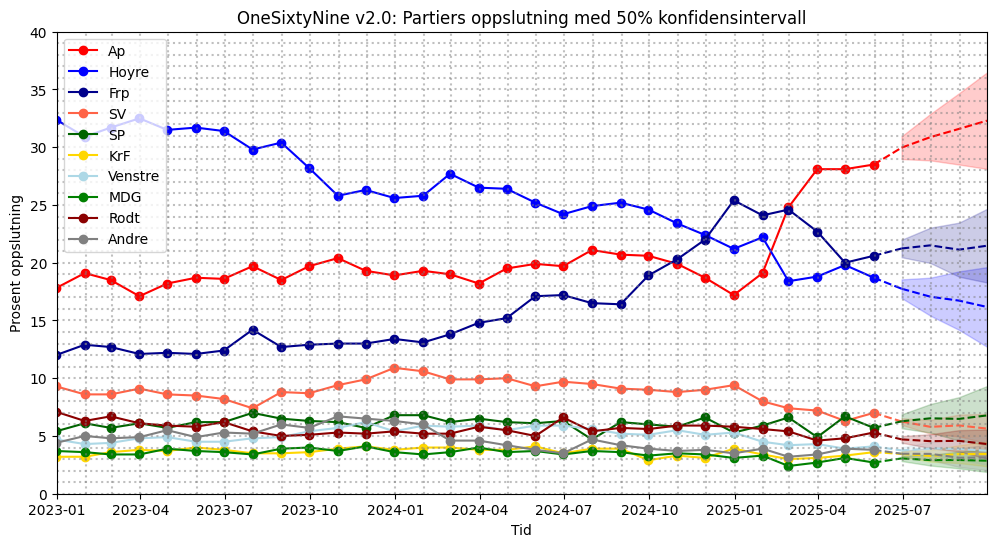

In [491]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [492]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [493]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)

     Party   Estimate      Lower      Upper
0       Ap  32.299240  28.126916  36.471563
1    Hoyre  16.171927  12.728318  19.615537
2      Frp  21.471092  18.285838  24.656346
3       SV   5.638481   4.360228   6.916735
4       SP   6.778868   4.239184   9.318553
5      KrF   3.438842   2.378397   4.499288
6  Venstre   3.722742   2.503979   4.941505
7      MDG   2.861062   1.880133   3.841990
8     Rodt   4.301003   3.042428   5.559578
9    Andre   3.144710   2.042189   4.247232


In [494]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.7977


In [495]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [496]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [497]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [498]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [499]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,54,49,29,9,9,7,9,2,3
1,60,31,32,12,9,8,8,8,3
2,63,30,40,3,10,3,3,2,7
3,57,23,39,8,17,3,7,3,9
4,42,31,49,8,17,3,3,2,11
...,...,...,...,...,...,...,...,...,...
999995,68,21,33,10,16,2,2,8,3
999996,53,43,44,2,3,2,3,3,2
999997,64,32,37,3,15,3,3,1,8
999998,66,26,43,10,9,9,2,2,2


In [500]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [501]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
0,54,49,29,9,9,7,9,2,3,171
1,60,31,32,12,9,8,8,8,3,171
2,63,30,40,3,10,3,3,2,7,161
3,57,23,39,8,17,3,7,3,9,166
4,42,31,49,8,17,3,3,2,11,166
...,...,...,...,...,...,...,...,...,...,...
999995,68,21,33,10,16,2,2,8,3,163
999996,53,43,44,2,3,2,3,3,2,155
999997,64,32,37,3,15,3,3,1,8,166
999998,66,26,43,10,9,9,2,2,2,169


In [502]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [503]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
5,64,40,28,13,2,7,2,3,10,169
13,64,18,46,14,10,9,3,2,3,169
24,68,32,35,9,9,8,2,3,3,169
31,59,27,40,12,16,8,2,2,3,169
35,62,35,37,10,11,1,3,2,8,169
...,...,...,...,...,...,...,...,...,...,...
999983,53,35,37,10,17,9,3,2,3,169
999987,58,30,30,12,18,9,2,2,8,169
999993,74,11,43,8,16,3,2,1,11,169
999994,49,33,42,11,11,8,3,2,10,169


In [504]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [505]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [506]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())

0.7895203887597718
0.04672512148742869
0.3310268328755546
0.6766955419395733
0.7895203887597718
0.018054088316078597
0.21047961124022818
0.3233044580604268


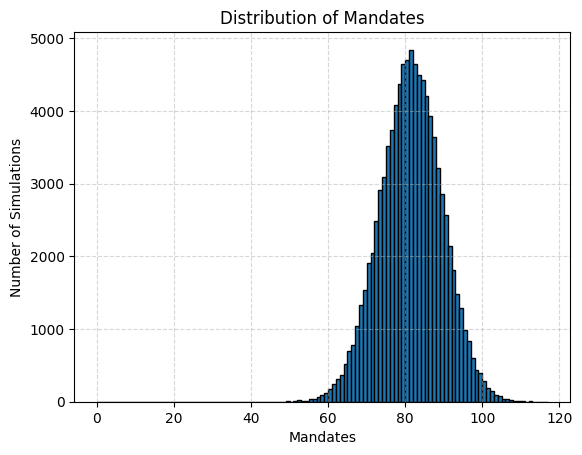

In [507]:
import matplotlib.pyplot as plt

plt.hist(sample_169['ap_sp_sv'], bins=range(0, sample_169['ap_sp_sv'].max() + 2), edgecolor='black')
plt.title('Distribution of Mandates')
plt.xlabel('Mandates')
plt.ylabel('Number of Simulations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()